In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monai
import matplotlib.pyplot as plt
from einops import rearrange
from oracle.models.base_transformer import VisionTransformer

C:\Users\David\.conda\envs\CandidateNet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
data_img_path = r'D:\Datasets\Decathlon\Task03_Liver\imagesTr\liver_16.nii.gz'
data_label_path = r'D:\Datasets\Decathlon\Task03_Liver\labelsTr\liver_16.nii.gz'
#data_img_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/imagesTr/liver_16.nii.gz"
#data_label_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/labelsTr/liver_16.nii.gz"

data_file = {'image': data_img_path, 'label': data_label_path}

In [4]:
load_im = monai.transforms.LoadImaged(keys=['image', 'label'])
chan_f = monai.transforms.EnsureChannelFirstD(keys=['image', "label"])
scale_intens = monai.transforms.ScaleIntensityRanged(keys='image', a_min=-21, a_max=189, b_min=0, b_max=1,clip=True)
to_t = monai.transforms.ToTensord(keys=["image", "label"])

data = to_t(scale_intens(chan_f(load_im(data_file))))

In [5]:
slice_max = 423

In [6]:
inputs = data['image'][:,:,:,slice_max].unsqueeze(0).to(device)
labels = data['label'][:,:,:,slice_max].unsqueeze(0).to(device)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def visualize_data(im, lab):
    plt.figure()
    plt.imshow(im.squeeze().cpu().numpy(), cmap='gray')
    plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)

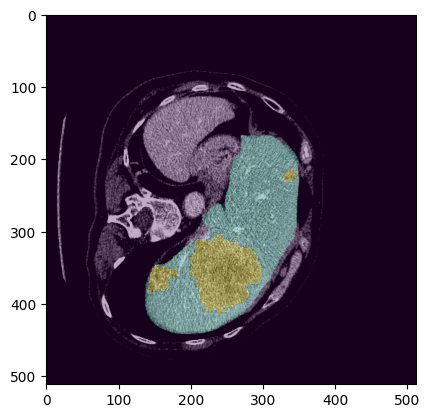

In [9]:
visualize_data(inputs, labels)

In [10]:
def create_oracle_labels(labels, patch_size): 
    max = F.max_pool2d(labels.float(), patch_size, stride=patch_size).to(torch.int32)
    min = F.max_pool2d(-labels.float(), patch_size, stride=patch_size).to(torch.int32)
    one_class = (max == -min)
    
    patch_groups_per_img = one_class.to(torch.uint8)
    
    return patch_groups_per_img.to(torch.long).squeeze(0)

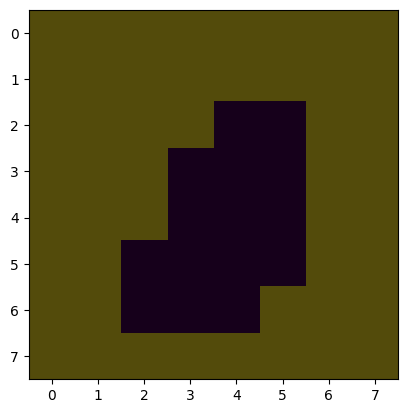

In [11]:
'''
patch_sizes_used = [64, 32]
oracle_labels_multires = []
for ps in patch_sizes_used:
    ol = create_policy_labels(labels, ps)
    visualize_data(inputs, ol)
    oracle_labels_multires.append(ol)
'''

oracle_labels = create_oracle_labels(labels, 64)
visualize_data(inputs, oracle_labels)

In [12]:
model = VisionTransformer(image_size=(512, 512),
                          patch_size=64,
                          n_layers=1,
                          d_model=64,
                          d_ff=256,
                          n_heads=4)
model = model.to(device)

In [13]:
inputs = inputs.to(device)
out = model(inputs, oracle_labels)

torch.Size([64, 3])
torch.Size([1, 64])


IndexError: too many indices for tensor of dimension 3

In [ ]:
out.shape

In [ ]:
data = torch.randn(1, 64, 16)

In [ ]:
patches = data.view(1, 8, 8, 16)

In [ ]:
patches_coords = torch.meshgrid(torch.arange(0,8), torch.arange(0,8))
patches_coords = torch.stack([patches_coords[0], patches_coords[1]])
patches_coords = patches_coords.permute(1,2,0)
patches_coords = patches_coords.view(-1, 2)

In [ ]:
patches_coords[8]